In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import ImageFolder
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import mobilenet_v2
from sklearn.metrics import accuracy_score


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



data_dir = '/kaggle/input/dataset1/Dataset 1/Colorectal Cancer '


classes = ['MUS', 'NORM', 'STR']


images = []
labels = []


for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.tif'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            images.append(image)
            labels.append(class_name)


X = np.array(images)
y = np.array(labels)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




Using cuda device


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.48009172777334846, Train Accuracy: 0.804375, Validation Loss: 1.3483397270503796, Validation Accuracy: 0.68
Epoch 2/20, Train Loss: 0.26750856436789033, Train Accuracy: 0.8972916666666667, Validation Loss: 2.268286855597245, Validation Accuracy: 0.465
Epoch 3/20, Train Loss: 0.18355026453733445, Train Accuracy: 0.9295833333333333, Validation Loss: 0.5569608611495871, Validation Accuracy: 0.8366666666666667
Epoch 4/20, Train Loss: 0.13341629874582092, Train Accuracy: 0.9527083333333334, Validation Loss: 0.6331162860519007, Validation Accuracy: 0.8216666666666667
Epoch 5/20, Train Loss: 0.09467968482834598, Train Accuracy: 0.9641666666666666, Validation Loss: 1.4843232694425081, Validation Accuracy: 0.61
Epoch 6/20, Train Loss: 0.07559090525532762, Train Accuracy: 0.974375, Validation Loss: 1.0347273977179277, Validation Accuracy: 0.7433333333333333
Epoch 7/20, Train Loss: 0.05231314895286535, Train Accuracy: 0.9833333333333333, Validation Loss: 1.40230699589377

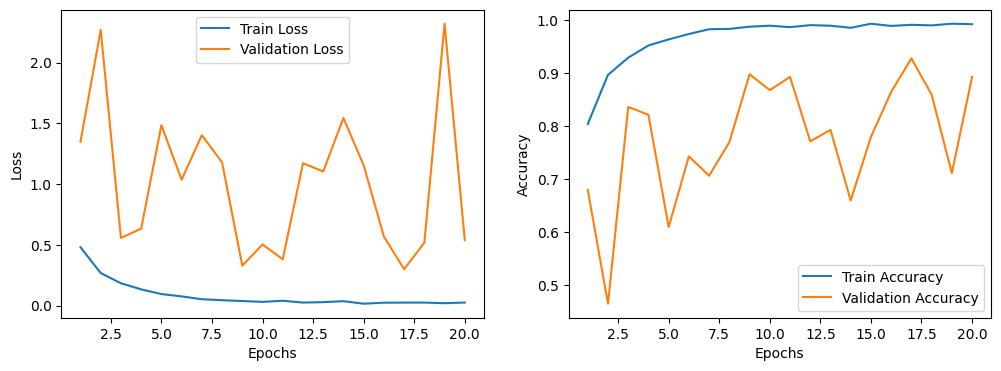

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define hyperparameters
batch_size = 32
learning_rate = 0.0001
epochs = 20

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),  # Ensure input is a PIL image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformations to your data
X_train_transformed = torch.stack([data_transform(x) for x in X_train])
X_val_transformed = torch.stack([data_transform(x) for x in X_val])

# Convert data to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_transformed, y_train_tensor)
val_dataset = TensorDataset(X_val_transformed, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define ResNet-18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training and Validation loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_loss = val_running_loss / len(val_loader)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Append to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

# Save the trained model
#torch.save(model.state_dict(), '/content/trained_resnet18.pth')

# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Using cuda device
Training with learning rate: 1e-09
Epoch 1/20, Train Loss: 1.2253860195477804, Train Accuracy: 0.325625, Validation Loss: 1.1941986397693032, Validation Accuracy: 0.36333333333333334
Epoch 2/20, Train Loss: 1.2253012327353159, Train Accuracy: 0.325625, Validation Loss: 1.1943325996398926, Validation Accuracy: 0.36333333333333334
Epoch 3/20, Train Loss: 1.22579256772995, Train Accuracy: 0.325625, Validation Loss: 1.1969258032347028, Validation Accuracy: 0.36333333333333334
Epoch 4/20, Train Loss: 1.2250945854187012, Train Accuracy: 0.325625, Validation Loss: 1.195346706791928, Validation Accuracy: 0.36333333333333334
Epoch 5/20, Train Loss: 1.224484277566274, Train Accuracy: 0.325625, Validation Loss: 1.1957709977501316, Validation Accuracy: 0.36333333333333334
Epoch 6/20, Train Loss: 1.2250103878974914, Train Accuracy: 0.325625, Validation Loss: 1.1942317109358938, Validation Accuracy: 0.36333333333333334
Epoch 7/20, Train Loss: 1.2246148705482482, Train Accuracy: 0.3

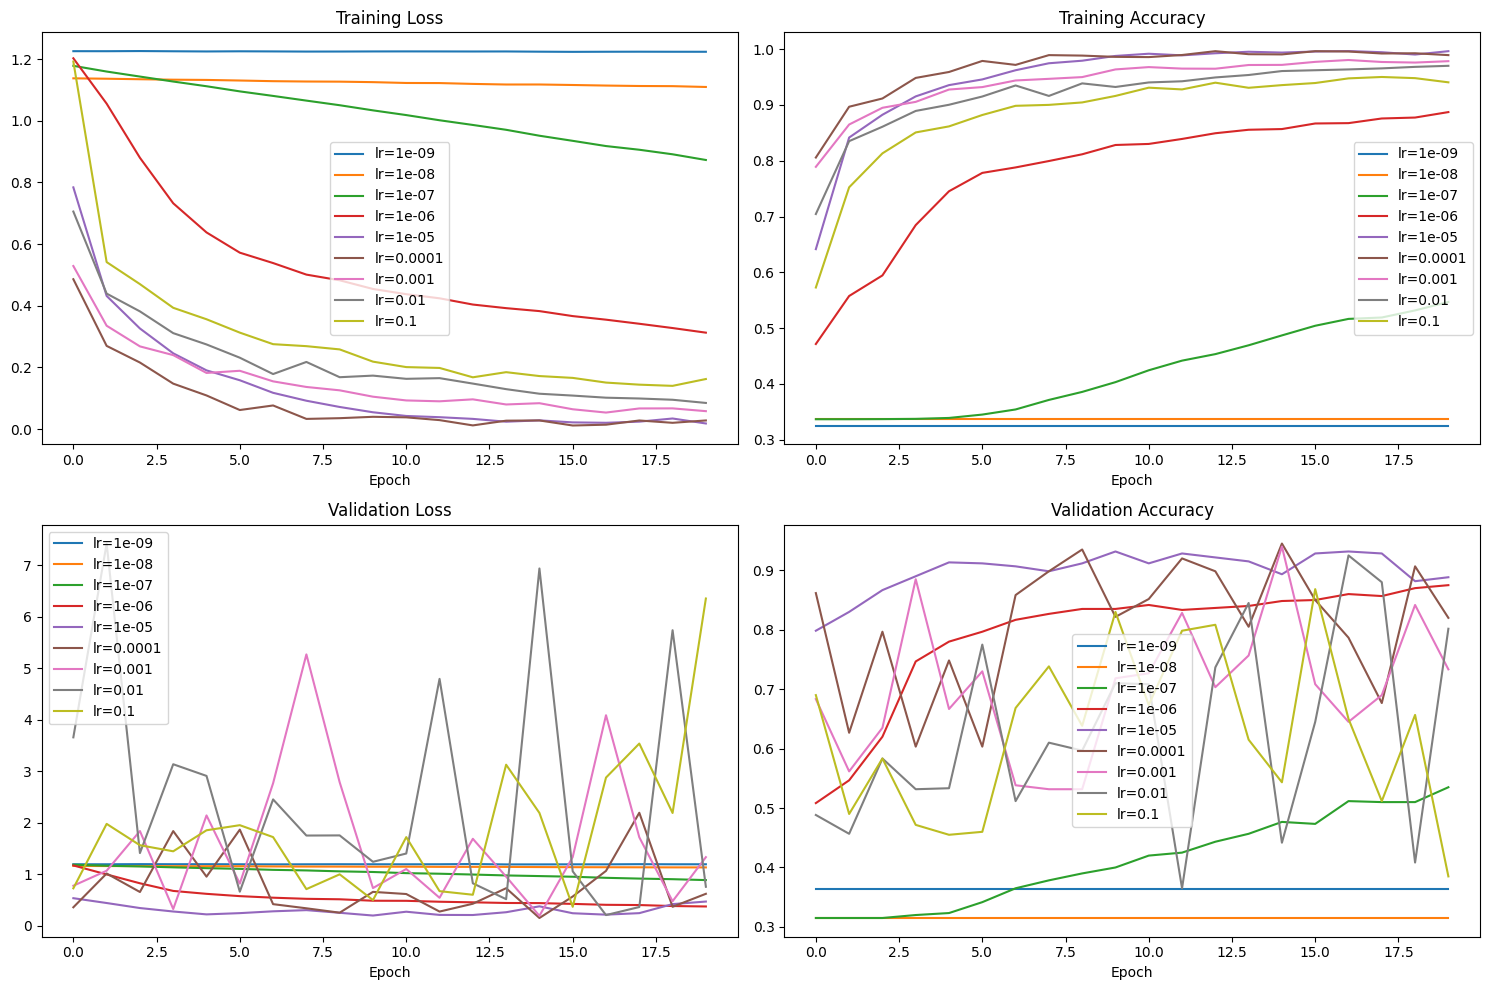

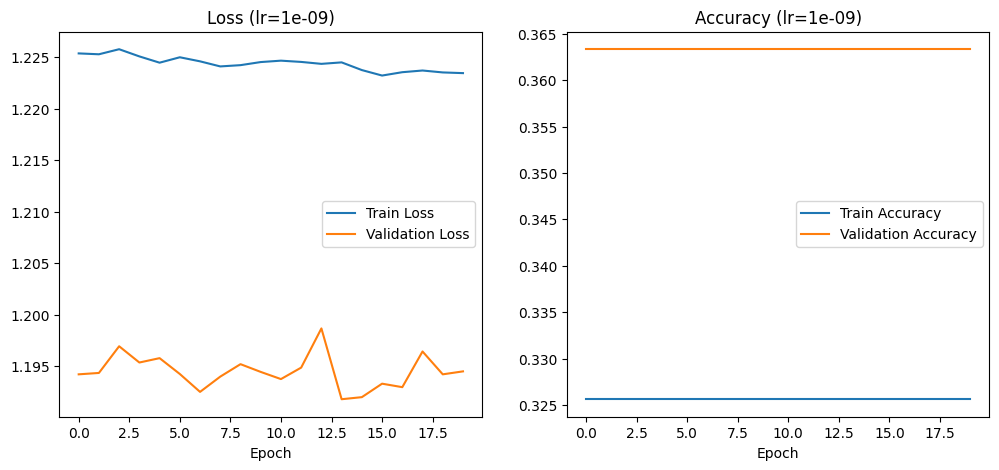

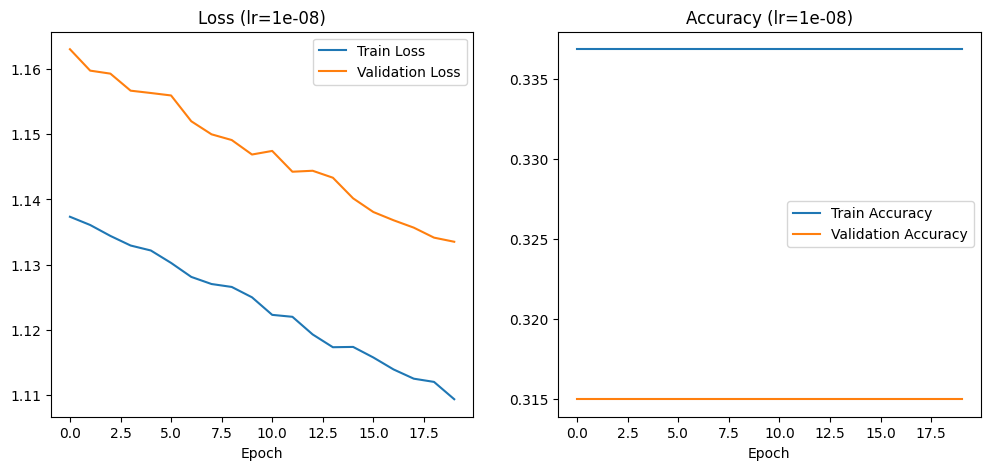

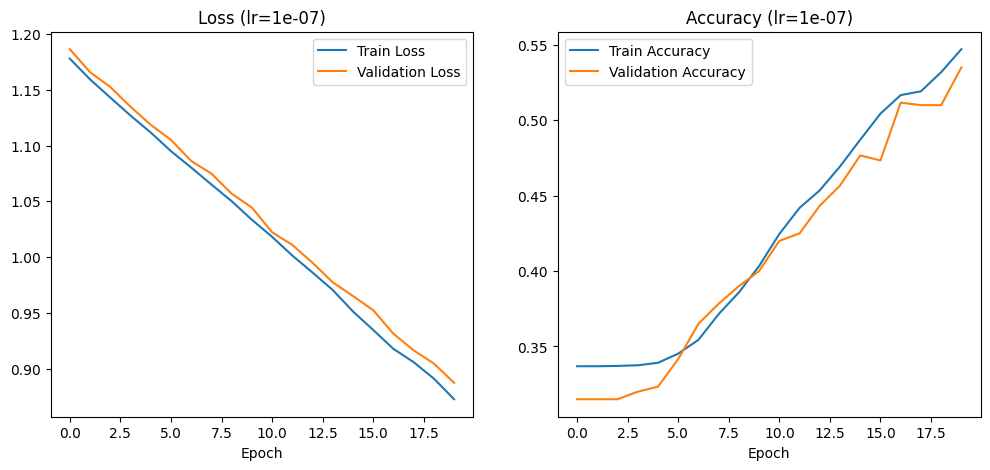

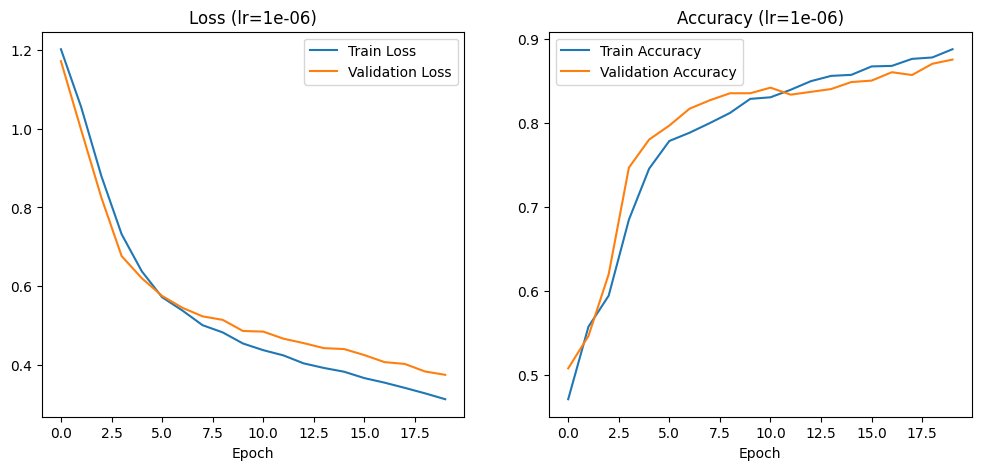

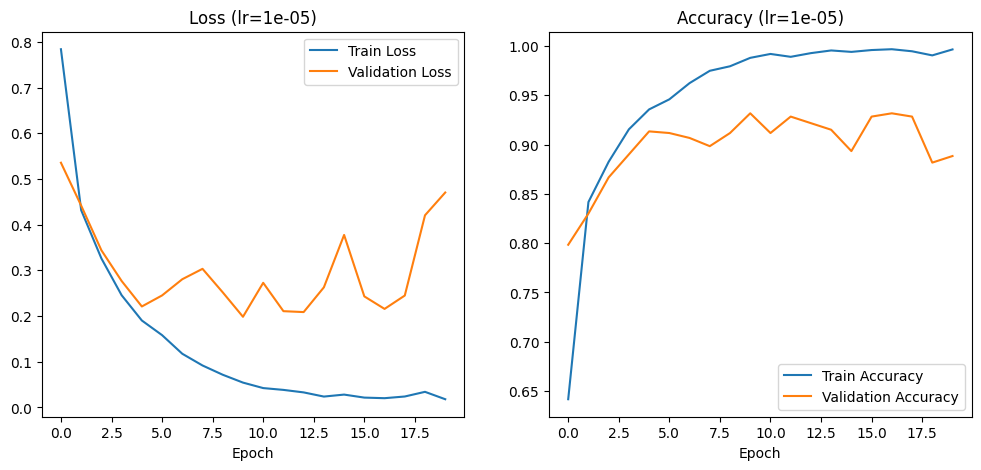

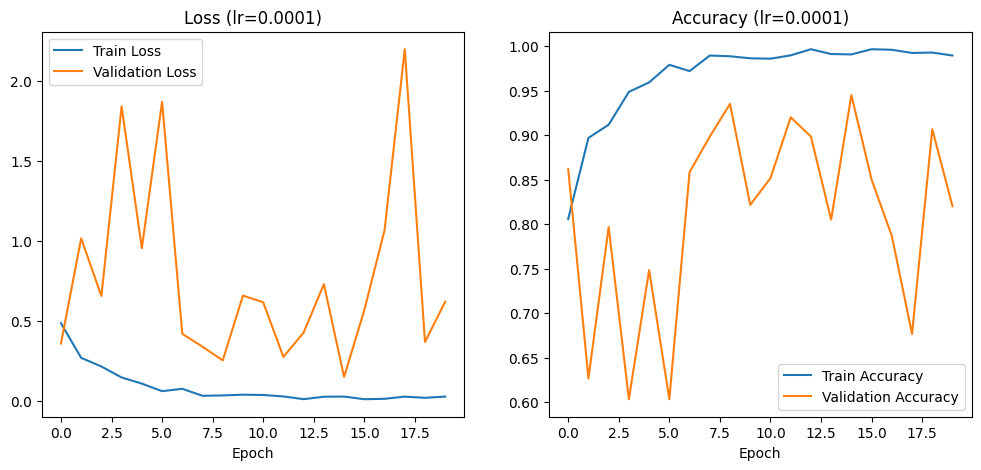

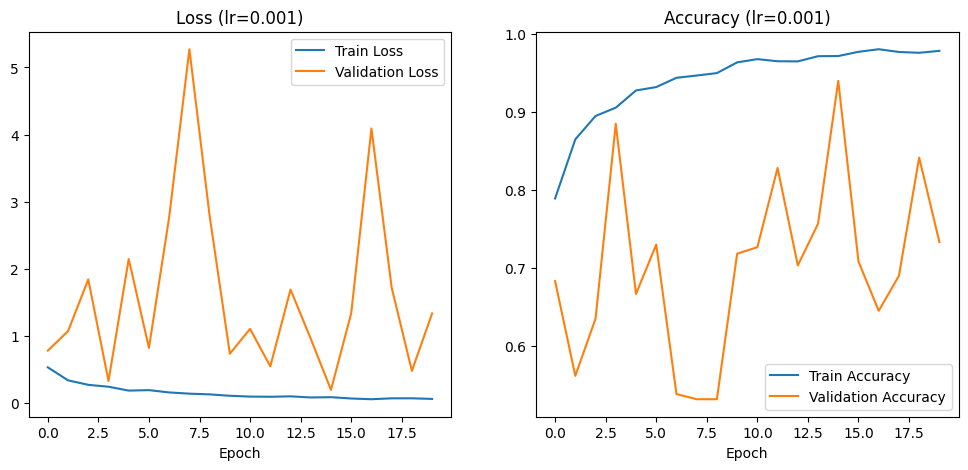

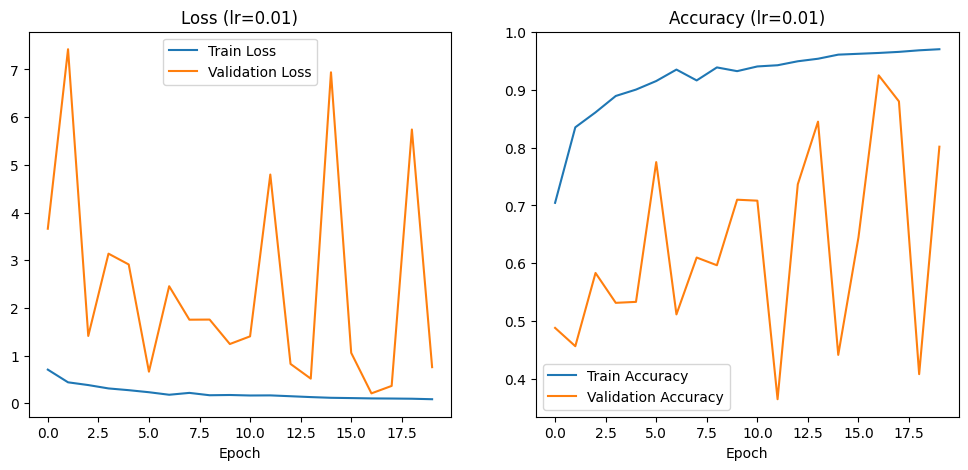

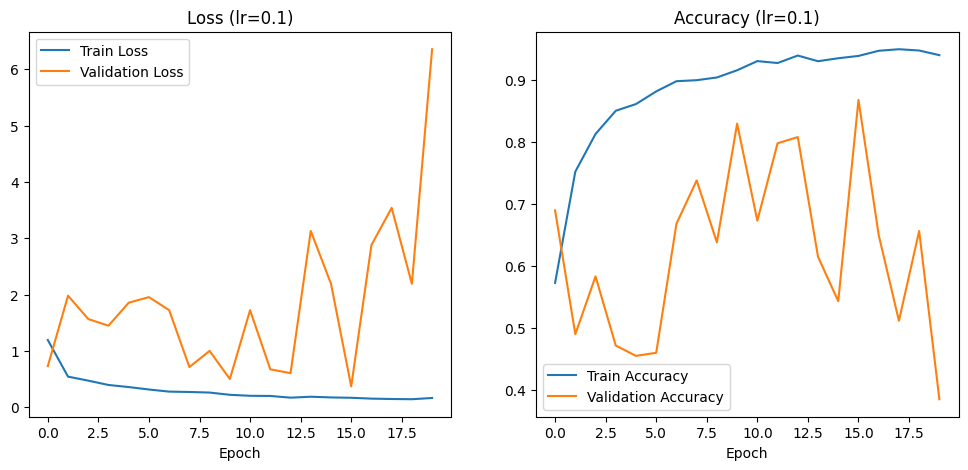

In [8]:
#hyper-parameter optimization with different learning rates to find the best one
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define hyperparameters
batch_size = 32
learning_rates = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]  # List of learning rates to try
epochs = 20

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),  # Ensure input is a PIL image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformations to your data
X_train_transformed = torch.stack([data_transform(x) for x in X_train])
X_val_transformed = torch.stack([data_transform(x) for x in X_val])

# Convert data to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_transformed, y_train_tensor)
val_dataset = TensorDataset(X_val_transformed, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define ResNet-18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Loop over different learning rates
results = {'lr': [], 'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

for lr in learning_rates:
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(f"Training with learning rate: {lr}")

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Training and Validation loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_loss = val_running_loss / len(val_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    results['lr'].append(lr)
    results['train_loss'].append(train_losses)
    results['train_accuracy'].append(train_accuracies)
    results['val_loss'].append(val_losses)
    results['val_accuracy'].append(val_accuracies)
    
    

# Save the trained model with the best lr
best_lr_index = results['val_accuracy'].index(max(results['val_accuracy']))
best_lr = results['lr'][best_lr_index]
best_model = model
#torch.save(best_model.state_dict(), f'/content/trained_resnet18_lr_{best_lr}.pth')

# Plot the results
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for i, lr in enumerate(learning_rates):
    plt.plot(results['train_loss'][i], label=f'lr={lr}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
for i, lr in enumerate(learning_rates):
    plt.plot(results['train_accuracy'][i], label=f'lr={lr}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
for i, lr in enumerate(learning_rates):
    plt.plot(results['val_loss'][i], label=f'lr={lr}')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
for i, lr in enumerate(learning_rates):
    plt.plot(results['val_accuracy'][i], label=f'lr={lr}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Plot the results
for i, lr in enumerate(learning_rates):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'][i], label='Train Loss')
    plt.plot(results['val_loss'][i], label='Validation Loss')
    plt.title(f'Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results['train_accuracy'][i], label='Train Accuracy')
    plt.plot(results['val_accuracy'][i], label='Validation Accuracy')
    plt.title(f'Accuracy (lr={lr})')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()
